In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import (
    train_test_split, cross_val_score, StratifiedKFold
)
from sklearn.preprocessing import RobustScaler, OrdinalEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier

from sklearn.metrics import (
    classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve
)


Carregamento e Pré-processamento dos Dados

In [ ]:
# Carregar
df = pd.read_csv("base/heart.csv")

# Remover casos inválidos
df = df[(df['Cholesterol'] != 0) & (df['RestingBP'] != 0)]

# Separar X e y
X = df.drop("HeartDisease", axis=1)
y = df["HeartDisease"]

# Definir variáveis
numeric_features = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']
binary_features = ['Sex', 'ExerciseAngina']
nominal_features = ['ChestPainType', 'RestingECG']
ordinal_features = ['ST_Slope']


 Pipelines de Pré-processamento

In [13]:
# Pipelines
numeric_transformer = Pipeline(steps=[
    ("scaler", RobustScaler())
])

binary_transformer = Pipeline(steps=[
    ("encoder", OrdinalEncoder())
])

nominal_transformer = Pipeline(steps=[
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

ordinal_transformer = Pipeline(steps=[
    ("encoder", OrdinalEncoder(categories=[['Up', 'Flat', 'Down']]))
])

# Combinar tudo
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("bin", binary_transformer, binary_features),
        ("nom", nominal_transformer, nominal_features),
        ("ord", ordinal_transformer, ordinal_features)
    ]
)


Modelos Base

In [14]:
# Definir modelos
models = {
    "Dummy": DummyClassifier(strategy="most_frequent"),
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "SVM": SVC(kernel="rbf", probability=True, random_state=42)
}


Avaliação com Cross-validation Estratificada (10-Fold)

In [15]:
results = []
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

for name, model in models.items():
    pipe = Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("classifier", model)
    ])
    
    cv_results = cross_val_score(pipe, X, y, cv=kfold, scoring="accuracy")
    results.append({
        "Model": name,
        "Mean Accuracy": cv_results.mean(),
        "Std Dev": cv_results.std()
    })

# Resultados em DataFrame
results_df = pd.DataFrame(results).sort_values(by="Mean Accuracy", ascending=False)
print(results_df)


                 Model  Mean Accuracy   Std Dev
3        Random Forest       0.868559  0.029104
4                  SVM       0.855225  0.031045
1  Logistic Regression       0.849838  0.038919
2        Decision Tree       0.777459  0.034158
0                Dummy       0.522811  0.003443


Visualização da Performance dos Modelos

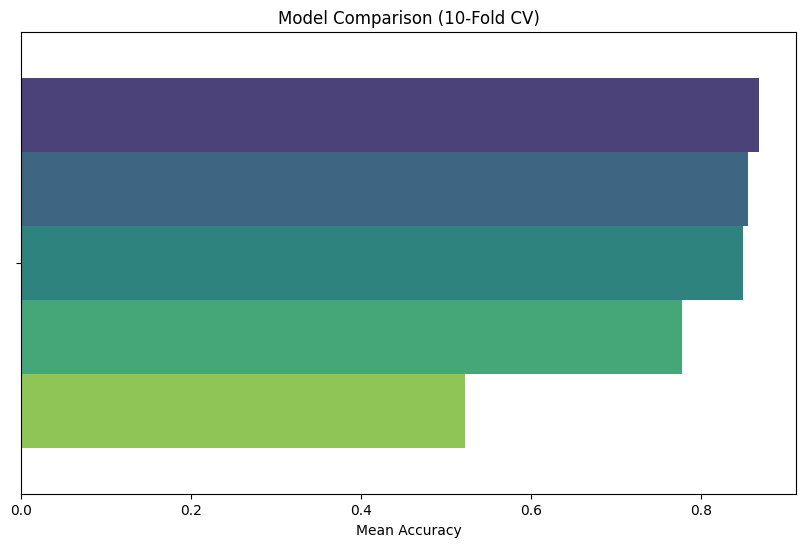

In [16]:
plt.figure(figsize=(10,6))
sns.barplot(data=results_df, x="Mean Accuracy", hue="Model", palette="viridis", legend=False)
plt.title("Model Comparison (10-Fold CV)")
plt.xlabel("Mean Accuracy")
plt.show()

Importância das Variáveis (RandomForest)

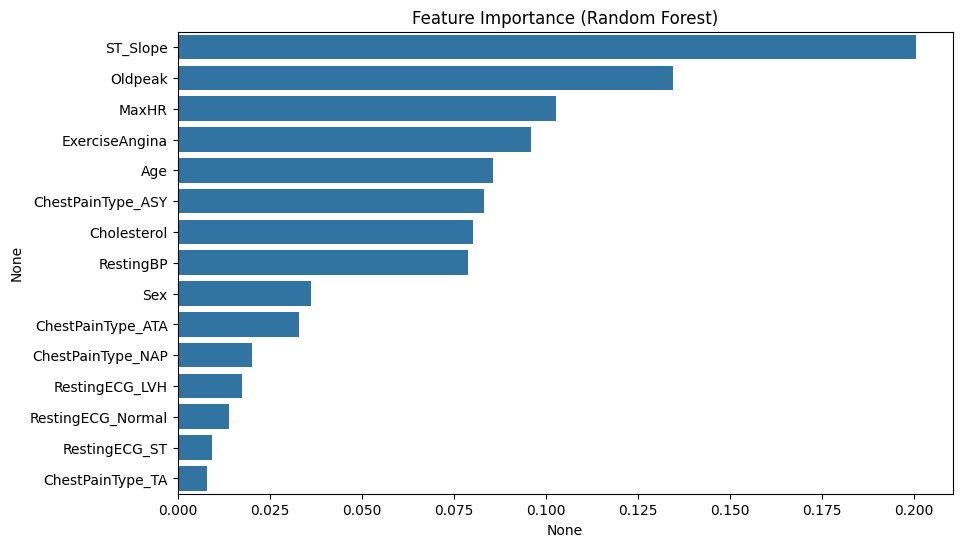

In [17]:
# Pipeline completo
rf_pipe = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", RandomForestClassifier(random_state=42))
])

rf_pipe.fit(X, y)

# Recuperar feature names após OneHotEncoder
ohe = rf_pipe.named_steps["preprocessor"].transformers_[2][1].named_steps["encoder"]
ohe_features = ohe.get_feature_names_out(nominal_features)

features = (
    numeric_features
    + binary_features
    + list(ohe_features)
    + ordinal_features
)

importances = rf_pipe.named_steps["classifier"].feature_importances_

# Plot
feat_imp = pd.Series(importances, index=features).sort_values(ascending=False)
plt.figure(figsize=(10,6))
sns.barplot(x=feat_imp, y=feat_imp.index)
plt.title("Feature Importance (Random Forest)")
plt.show()


Análise de Threshold — Curva ROC e Curva Precision-Recall

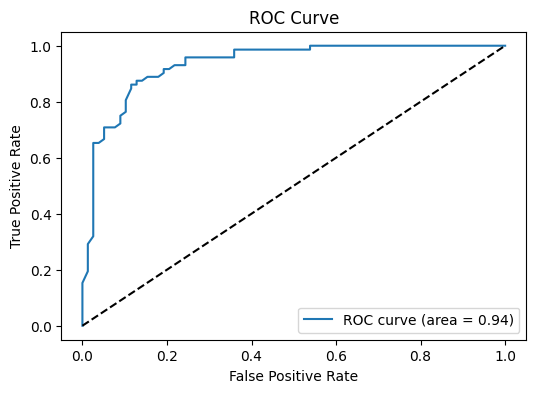

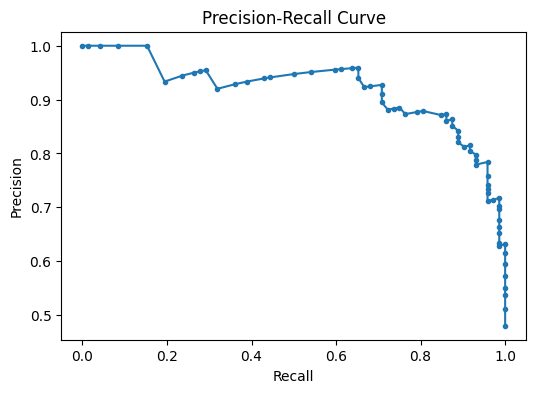

In [18]:
# Gerar dados de treino/teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Pipeline com RandomForest
model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", RandomForestClassifier(random_state=42))
])

model.fit(X_train, y_train)
y_probs = model.predict_proba(X_test)[:, 1]

# ROC
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()

# Precision-Recall
precision, recall, thresholds = precision_recall_curve(y_test, y_probs)

plt.figure(figsize=(6,4))
plt.plot(recall, precision, marker=".")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.show()


Ajuste Manual de Threshold

              precision    recall  f1-score   support

           0       0.89      0.82      0.85        78
           1       0.82      0.89      0.85        72

    accuracy                           0.85       150
   macro avg       0.85      0.85      0.85       150
weighted avg       0.86      0.85      0.85       150



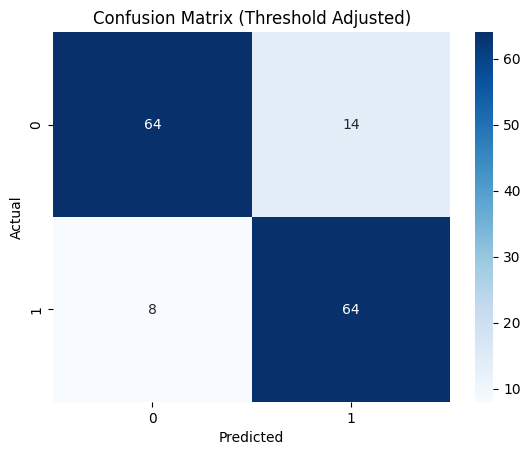

In [19]:
optimal_threshold = 0.4  # Exemplo, ajustar após observar curva

y_pred_adjusted = (y_probs >= optimal_threshold).astype(int)

print(classification_report(y_test, y_pred_adjusted))

cm = confusion_matrix(y_test, y_pred_adjusted)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (Threshold Adjusted)")
plt.show()
